In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

## Warm dark matter

You can easily generate realizations of warm dark matter halos using the preset model WDM.


First, we'll create a CDM relation as a point of comparison

realization contains 19391 halos.


Text(0,0.5,'n(M)')

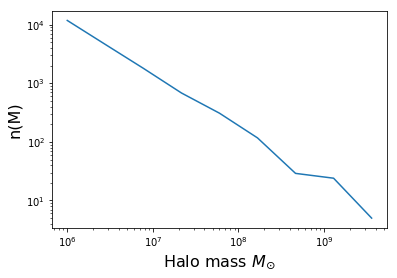

In [2]:
from pyHalo.preset_models import CDM

zlens, zsource = 0.5, 2.5
realizationCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=10)
print('realization contains '+str(len(realizationCDM.halos))+' halos.')
cdm_halo_masses = [halo.mass for halo in realizationCDM.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

plt.loglog(m[0:-1], N)
plt.xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
plt.ylabel('n(M)', fontsize=16)

### WDM rendering

WDM models are parameterized relative to CDM, with a suppression added to both the halo mass function and concentration-mass relation. Currently, pyHalo models these suppressions with fixed functional forms through a function $f$. For the mass funciton, the code uses

\begin{equation}
f = \left(1 + a\times u ^b\right)^{c}
\end{equation}
where $a$, $b$, and $c$ are free parameters, and $u \equiv \frac{m_{\rm{hm}}}{m}$. $a$, $b$, and $c$ can be different for subhalos and field halos. 

The defult suppression for the concentration-mass relation has the form

\begin{equation}
f = \left(1 + c_{\rm{scale}} u \right)^{c_{\rm{power}} } \times \left(1 + z\right)^{0.026z - 0.04}
\end{equation}

The redshift evolution is currently hard-coded into this model. The functional form, redshift evolution, and default values ($c_{\rm{scale}}, c_{\rm{power}}$) = (60, -0.017) were computed by Bose et al. (2016). 

An alternative expression for the suppression of the concentration-mass relation is through a hyperbolic suppression term

\begin{equation}
f = \frac{1}{2} \left(1 + \tanh \left(\frac{u - a_{\rm{mc}}}{b_{\rm{mc}}}\right) \right)
\end{equation}


realization contains 2436 halos.


Text(0,0.5,'n(M)')

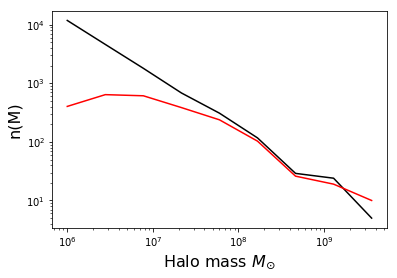

In [3]:
from pyHalo.preset_models import WDM

log10_half_mode_mass = 7.

# These can be different for subhalos and line-of-sight halos
a_wdm_sub = 0.5
b_wdm_sub = 0.8
c_wdm_sub = -3.0
a_wdm_los = 0.5
b_wdm_los = 0.8
c_wdm_los = -3.0


kwargs_wdm = {'a_wdm_los': a_wdm_los, 'a_wdm_sub': a_wdm_sub, 'b_wdm_los': b_wdm_los, 'b_wdm_sub': b_wdm_sub, 
             'c_wdm_los': c_wdm_los, 'c_wdm_sub': c_wdm_sub}

realizationWDM = WDM(zlens, zsource, log10_half_mode_mass, cone_opening_angle_arcsec=10, **kwargs_wdm)

print('realization contains '+str(len(realizationWDM.halos))+' halos.')
wdm_halo_masses = [halo.mass for halo in realizationWDM.halos]
Nwdm, mwdm = np.histogram(wdm_halo_masses, bins=np.logspace(6, 10, 10))

plt.loglog(m[0:-1], N, color='k')
plt.loglog(mwdm[0:-1], Nwdm, color='r')
plt.xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
plt.ylabel('n(M)', fontsize=16)

### Visualize the convergence

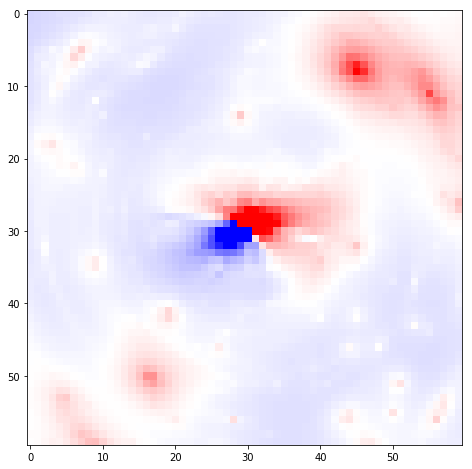

In [4]:
# power law plus shear macromodel
from lenstronomy.LensModel.lens_model import LensModel
astropy_instance = realizationWDM.astropy_instance
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.04, 'gamma2': 0.09}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

lens_model_list_WDM, lens_redshift_array_WDM, kwargs_halos_WDM, _ = realizationWDM.lensing_quantities()
lens_model_list_full_WDM = lens_model_list_macro + lens_model_list_WDM
lens_redshift_list_full_WDM = [zlens, zlens] + list(lens_redshift_array_WDM)
kwargs_lens_full_WDM = kwargs_macromodel + kwargs_halos_WDM

lens_model_full_WDM = LensModel(lens_model_list_full_WDM, zlens, zsource, lens_redshift_list_full_WDM, 
                                cosmo=astropy_instance, multi_plane=True)

npix = 60 
_x = _y = np.linspace(-1.2, 1.2, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa_full_WDM = lens_model_full_WDM.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full_WDM).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

fig = plt.figure(1)
fig.set_size_inches(8,8)
plt.imshow(kappa_full_WDM - kappa_macro, vmin=-0.1, vmax=0.1, cmap='bwr')

### WDM concentration-mass relations

The defult implementation is through the polynomial suppression 

\begin{equation}
f = \left(1 + c_{\rm{scale}} u \right)^{c_{\rm{power}} } \times \left(1 + z\right)^{0.026z - 0.04}
\end{equation}

Note that the m-c relation turns over at a much higher mass scale than the mass function. The scatter in the mc-relation is set to 0.2 dex. 

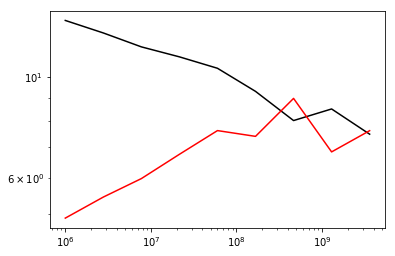

In [5]:
halo_concentrations_cdm = np.array([halo.c for halo in realizationCDM.halos])
halo_concentrations_wdm = np.array([halo.c for halo in realizationWDM.halos])
halo_masses = np.logspace(6, 10, 10)

mc_relation_cdm = []
mc_relation_wdm = []

for i in range(0, len(halo_masses)-1):
    
    condition = np.logical_and(cdm_halo_masses >= halo_masses[i], cdm_halo_masses<halo_masses[i+1])
    inds = np.where(condition)
    c = halo_concentrations_cdm[inds]
    mc_relation_cdm.append(np.median(c))
    
    condition = np.logical_and(wdm_halo_masses >= halo_masses[i], wdm_halo_masses<halo_masses[i+1])
    inds = np.where(condition)
    c = halo_concentrations_wdm[inds]
    mc_relation_wdm.append(np.median(c))

plt.loglog(halo_masses[0:-1], mc_relation_cdm, color='k')
plt.loglog(halo_masses[0:-1], mc_relation_wdm, color='r')

### WDM concentration-mass relations cont.

You can implement another form for the suppression in the concentration-mass relation

\begin{equation}
f = \frac{1}{2} \left(1 + \tanh \left(\frac{u - a_{\rm{mc}}}{b_{\rm{mc}}}\right) \right)
\end{equation}

The parameters a and b can be different for subhalos and field halos. You can implement it as follows

In [6]:
log10_half_mode_mass = 7.
# Keep the mass function the same
a_wdm_sub = 0.5
b_wdm_sub = 0.8
c_wdm_sub = -3.0
a_wdm_los = 0.5
b_wdm_los = 0.8
c_wdm_los = -3.0

suppression_model_mcrelation = 'hyperbolic'
kwargs_suppresion_model_mcrelation = {'a_mc': 0.25, 'b_mc': 0.5}
kwargs_wdm = {'a_wdm_los': a_wdm_los, 'a_wdm_sub': a_wdm_sub, 'b_wdm_los': b_wdm_los, 'b_wdm_sub': b_wdm_sub, 
             'c_wdm_los': c_wdm_los, 'c_wdm_sub': c_wdm_sub, 
              'suppression_model_sub': suppression_model_mcrelation,
              'suppression_model_field': suppression_model_mcrelation,
              'kwargs_suppression_sub': kwargs_suppresion_model_mcrelation,
              'kwargs_suppression_field': kwargs_suppresion_model_mcrelation}

realizationWDM_hyperbolic_mc = WDM(zlens, zsource, log10_half_mode_mass, cone_opening_angle_arcsec=10, **kwargs_wdm)
halos_wdm_2 = realizationWDM_hyperbolic_mc.halos

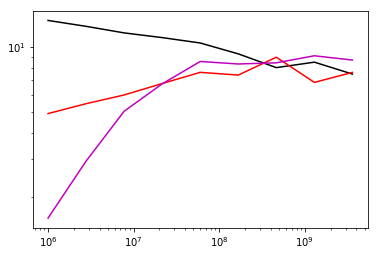

In [7]:
halo_concentrations_wdm_hyperbolic = np.array([halo.c for halo in realizationWDM_hyperbolic_mc.halos])
mc_relation_wdm_hyperbolic = []
wdm_halo_masses = np.array([halo.mass for halo in halos_wdm_2])

for i in range(0, len(halo_masses)-1):
    
    condition = np.logical_and(wdm_halo_masses >= halo_masses[i], wdm_halo_masses<halo_masses[i+1])
    inds = np.where(condition)
    c = halo_concentrations_wdm_hyperbolic[inds]
    mc_relation_wdm_hyperbolic.append(np.median(c))

plt.loglog(halo_masses[0:-1], mc_relation_cdm, color='k')
plt.loglog(halo_masses[0:-1], mc_relation_wdm, color='r')
plt.loglog(halo_masses[0:-1], mc_relation_wdm_hyperbolic, color='m')